# Rustpix Python bindings quickstart

This notebook shows the core Python API for reading hits, clustering, and extracting neutrons.

## Setup

From the repo root:

- `pixi install`
- `pixi run build`
- `pixi run -e jupyter notebook`

In [1]:
import rustpix
from pathlib import Path
import time
import numpy as np
import matplotlib.pyplot as plt


## Select a TPX3 file

In [2]:
path = Path("../tmp_test_data/test_data/Run_8217_April25_2025_Ni_Powder_MCP_TPX3_0_8C_1_9_AngsMin_serval_000000.tpx3")
if not path.exists():
    print("Set 'path' to a valid .tpx3 file before running the cells below.")

## Read hits (SoA)

This returns a `HitBatch` backed by the Rust core. Use `to_numpy()` to get a dict of NumPy arrays.

In [3]:
if path.exists():
    detector = rustpix.DetectorConfig.venus_defaults()
    t0 = time.perf_counter()
    hits = rustpix.read_tpx3_hits(str(path), detector_config=detector, time_ordered=True)
    dt = time.perf_counter() - t0
    print(f"hits: {hits.len()}")
    if dt > 0:
        print(f"read hits in {dt:.2f}s ({hits.len() / dt:,.0f} hits/s)")
    hits_meta = hits.metadata()
    print("Note: hits.to_numpy() moves data. Cluster first, then convert, or re-read.")


hits: 736028562
read hits in 25.48s (28,885,523 hits/s)
Note: hits.to_numpy() moves data. Cluster first, then convert, or re-read.


## Cluster hits -> neutrons

You can cluster a `HitBatch` directly and extract neutrons in one call.

neutrons: 113292025
cluster+extract in 18.37s (40,076,416 hits/s, 6,168,699 neutrons/s)


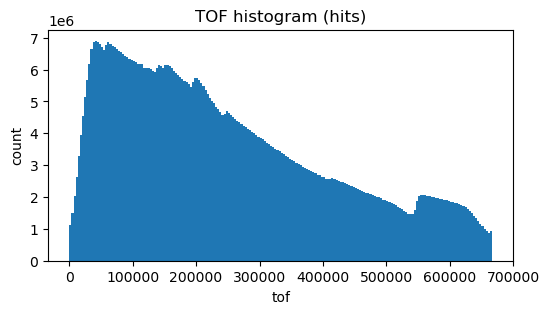

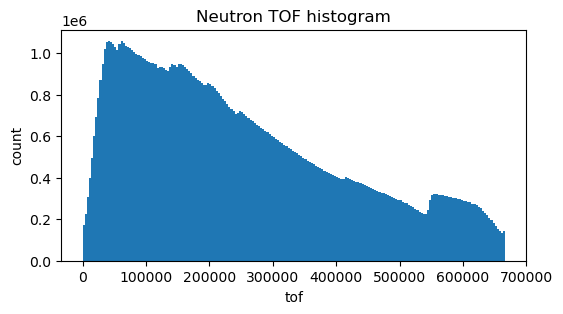

In [4]:
if path.exists():
    clustering = rustpix.ClusteringConfig(radius=5.0, temporal_window_ns=75.0, min_cluster_size=1)
    extraction = rustpix.ExtractionConfig()
    hit_count = hits.len()
    t0 = time.perf_counter()
    neutrons = rustpix.cluster_hits(
        hits,
        clustering_config=clustering,
        extraction_config=extraction,
        algorithm="abs",
    )
    dt = time.perf_counter() - t0
    print(f"neutrons: {neutrons.len()}")
    if dt > 0:
        print(f"cluster+extract in {dt:.2f}s ({hit_count / dt:,.0f} hits/s, {neutrons.len() / dt:,.0f} neutrons/s)")

    # Optional: histogram hits (consume hit batch)
    hits_np = hits.to_numpy()
    plt.figure(figsize=(6, 3))
    plt.hist(hits_np["tof"], bins=200)
    plt.title("TOF histogram (hits)")
    plt.xlabel("tof")
    plt.ylabel("count")
    plt.show()

    neutrons_np = neutrons.to_numpy()
    plt.figure(figsize=(6, 3))
    plt.hist(neutrons_np["tof"], bins=200)
    plt.title("Neutron TOF histogram")
    plt.xlabel("tof")
    plt.ylabel("count")
    plt.show()


## TPX3 -> neutrons (streaming default)

This path streams time-ordered hits from disk, clusters, and extracts without materializing the whole file.

In [5]:
if path.exists():
    t0 = time.perf_counter()
    neutron_stream = rustpix.process_tpx3_neutrons(
        str(path),
        algorithm="abs",
        time_ordered=True,
    )
    total_neutrons = 0
    for batch in neutron_stream:
        total_neutrons += batch.len()
    dt = time.perf_counter() - t0
    print(f"neutrons (streaming): {total_neutrons}")
    if dt > 0:
        print(f"streamed in {dt:.2f}s ({total_neutrons / dt:,.0f} neutrons/s)")


neutrons (streaming): 113292025
streamed in 43.54s (2,601,790 neutrons/s)


## Stream hits in batches

Use this to process huge files without loading all hits at once.

In [6]:
if path.exists():
    stream = rustpix.stream_tpx3_hits(str(path))
    total = 0
    t0 = time.perf_counter()
    for i, batch in enumerate(stream):
        total += batch.len()
        if i == 2:
            break
    dt = time.perf_counter() - t0
    print(f"processed hits in 3 batches: {total}")
    if dt > 0:
        print(f"partial stream rate: {total / dt:,.0f} hits/s")


processed hits in 3 batches: 62161
partial stream rate: 29,402,124 hits/s
